---
### *The 12th Computational Neuroscience Winter School*

# Tutorial II: Neuron software
---
__Date:__ Jan. 13, 2023

__Content Creator:__ Jingyang Ma, Ziling Wang, Kai Chen, Songting Li

# Tutorial Objectives

In this notebook, we'll learn how to use the Neuron software in python to build the biophysical neuron(or neuronal network) and do some simulations as we like. There are 4 sections in this tutorial:

1. Simulation of  a point neuron
1. Simulation of neuron with dendtrites
1. Simulation of neuronal network
1. Simulation of a real neuron from ModelDB

#### References:
- https://www.neuron.yale.edu/neuron/static/py_doc/index.html
- https://neuronaldynamics.epfl.ch
- https://senselab.med.yale.edu/ModelDB/
- Li, S., Liu, N., Zhang, X., Zhou, D., Cai, D. (2014) Bilinearity in spatiotemporal integration of synaptic inputs. PLoS Comput Biol.
- Li, S., Liu, N., Zhang, X., McLaughlin, D. W., Zhou, D., & Cai, D. (2019). Dendritic computations captured by an effective point neuron model. Proceedings of the National Academy of Sciences.
- Hay E, Hill S, Schürmann F, Markram H, Segev I (2011) Models of Neocortical Layer 5b Pyramidal Cells Capturing a Wide Range of Dendritic and Perisomatic Active Properties. PLoS Comput Biol.

# Section 2: Simulation of a neuron with dendrites

In [2]:
from neuron import h
from neuron.units import ms, mV
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pickle

Normally, we are more interested in the neuron with spatial structures instead of the simple point neuron. In NEURON software, we also use the **h.Section(cylinder)** to represent the dendrites.

<center class='half'>
    <img src='./pictures/morpho.png' width='500'/>
    <img src='./pictures/morpho2.png' width='500'/>
</center>

## Step 1: Defining the cell morphology

A ball-and-stick cell by definition consists of two parts: the soma (ball) and a dendrite (stick). We could define two Sections at the top level as in the previous tutorial, but that wouldn't give us an easy way to create multiple cells. Instead, let's define a BallAndStick neuron class. The basic boilerplate for defining any class in Python looks like:

In [3]:
class BallAndStick:
    def __init__(self, gid):
        self._gid = gid
        self.soma = h.Section(name='soma', cell=self)
        self.dend = h.Section(name='dend', cell=self)
    def __repr__(self):
        return 'BallAndStick[{}]'.format(self._gid)

In [4]:
my_cell = BallAndStick(0)

In [5]:
h.topology()


|-|       BallAndStick[0].soma(0-1)
|-|       BallAndStick[0].dend(0-1)



1.0

In [6]:
my_other_cell = BallAndStick(1)

In [7]:
h.topology()


|-|       BallAndStick[0].soma(0-1)
|-|       BallAndStick[0].dend(0-1)
|-|       BallAndStick[1].soma(0-1)
|-|       BallAndStick[1].dend(0-1)



1.0

For now, we can get rid of my_other_cell:

In [8]:
del my_other_cell

In [9]:
h.topology()


|-|       BallAndStick[0].soma(0-1)
|-|       BallAndStick[0].dend(0-1)



1.0

### Connect the sections

![morpho3](./pictures/morpho3.png)

We attach self.dend to the self.soma using the connect method:

In [10]:
class BallAndStick:
    def __init__(self, gid):
        self._gid = gid
        self.soma = h.Section(name='soma', cell=self)
        # self.dend = [h.Section(name='dend[%d]' % i, cell=self) for i in range(2)] # We can also use a list to store all the dendrites
        self.dend0 = h.Section(name='dend0', cell=self)
        self.dend1 = h.Section(name='dend1', cell=self)
        self.dend0.connect(self.soma(0))
        self.dend1.connect(self.soma(1))
    def __repr__(self):
        return 'BallAndStick[{}]'.format(self._gid)

In [11]:
my_cell = BallAndStick(0)

In [12]:
h.topology()


|-|       BallAndStick[0].soma(0-1)
   `|       BallAndStick[0].dend1(0-1)
 `|       BallAndStick[0].dend0(0-1)



1.0

### Define stylized geometry

Let's set the length and the width for both sections. We'll make the soma have length and diameter of 12.6157 microns, the dendrite have length 200 microns and diameter 1 micron.

In [13]:
class BallAndStick:
    def __init__(self, gid):
        self._gid = gid
        self.soma = h.Section(name='soma', cell=self)
        # self.dend = [h.Section(name='dend[%d]' % i, cell=self) for i in range(2)] # We can also use a list to store all the dendrites
        self.dend0 = h.Section(name='dend0', cell=self)
        self.dend1 = h.Section(name='dend1', cell=self)
        self.dend0.connect(self.soma(0))
        self.dend1.connect(self.soma(1))
        self.soma.L = self.soma.diam = 12.6157
        self.dend0.L = 200
        self.dend0.diam = 1
        self.dend1.L = 100
        self.dend1.diam = 2
    def __repr__(self):
        return 'BallAndStick[{}]'.format(self._gid)

my_cell = BallAndStick(0)

In [14]:
my_cell.soma(0.5).area()

500.00296377255506

In [14]:
h.topology()


|-|       BallAndStick[0].soma(0-1)
   `|       BallAndStick[0].dend1(0-1)
 `|       BallAndStick[0].dend0(0-1)



1.0

## Step 2:  Specify biophysics

Our cell needs biophysical mechanisms in the membrane. We start by setting axial resistance and membrane capacitance. (Recall: NEURON's default axial resistance is appropriate for squid but low for mammalian models.)

In [16]:
class BallAndStick:
    def __init__(self, gid):
        self._gid = gid
        self.soma = h.Section(name='soma', cell=self)
        # self.dend = [h.Section(name='dend[%d]' % i, cell=self) for i in range(2)] # We can also use a list to store all the dendrites
        self.dend0 = h.Section(name='dend0', cell=self)
        self.dend1 = h.Section(name='dend1', cell=self)
        self.all = [self.soma, self.dend0, self.dend1]                                     
        self.dend0.connect(self.soma(0))
        self.dend1.connect(self.soma(1))
        self.soma.L = self.soma.diam = 12.6157
        self.dend0.L = 200
        self.dend0.diam = 1
        self.dend1.L = 100
        self.dend1.diam = 2
        for sec in self.all:                                                  # <-- NEW
            sec.Ra = 100    # Axial resistance in Ohm * cm                    # <-- NEW
            sec.cm = 1      # Membrane capacitance in micro Farads / cm^2     # <-- NEW
    def __repr__(self):
        return 'BallAndStick[{}]'.format(self._gid)

my_cell = BallAndStick(0)

We've added a new variable **self.all** which is a list of all the sections in the cell. This will help us iterate over them to -- in this case -- specify axial resistance and membrane capacitance, but can also be used for any other biophysics.

This is getting a little complicated. Let's split __init__ into several functions:

In [18]:
class BallAndStick:
    def __init__(self, gid):
        self._gid = gid
        self._setup_morphology()
        self._setup_biophysics()

    def _setup_morphology(self):
        self.soma = h.Section(name='soma', cell=self)
        # self.dend = [h.Section(name='dend[%d]' % i, cell=self) for i in range(2)] # We can also use a list to store all the dendrites
        self.dend0 = h.Section(name='dend0', cell=self)
        self.dend1 = h.Section(name='dend1', cell=self)
        self.all = [self.soma, self.dend0, self.dend1]                                     # <-- NEW
        self.dend0.connect(self.soma(0))
        self.dend1.connect(self.soma(1))
        self.soma.L = self.soma.diam = 12.6157
        self.dend0.L = 200
        self.dend0.diam = 1
        self.dend1.L = 100
        self.dend1.diam = 2

    def _setup_biophysics(self):
        for sec in self.all:
            sec.Ra = 100    # Axial resistance in Ohm * cm
            sec.cm = 1      # Membrane capacitance in micro Farads / cm^2
            
    def __repr__(self):
        return 'BallAndStick[{}]'.format(self._gid)

my_cell = BallAndStick(0)

We'll put Hodgkin-Huxley (hh) kinetics in the soma and specify some parameters:

In [19]:
class BallAndStick:
    def __init__(self, gid):
        self._gid = gid
        self._setup_morphology()
        self._setup_biophysics()
    def _setup_morphology(self):
        self.soma = h.Section(name='soma', cell=self)
        # self.dend = [h.Section(name='dend[%d]' % i, cell=self) for i in range(2)] # We can also use a list to store all the dendrites
        self.dend0 = h.Section(name='dend0', cell=self)
        self.dend1 = h.Section(name='dend1', cell=self)
        self.all = [self.soma, self.dend0, self.dend1]                                     
        self.dend0.connect(self.soma(0))
        self.dend1.connect(self.soma(1))
        self.soma.L = self.soma.diam = 12.6157
        self.dend0.L = 200
        self.dend0.diam = 1
        self.dend1.L = 100
        self.dend1.diam = 2
    def _setup_biophysics(self):
        for sec in self.all:
            sec.Ra = 100    # Axial resistance in Ohm * cm
            sec.cm = 1      # Membrane capacitance in micro Farads / cm^2
        self.soma.insert('hh')                                                    # <-- NEW           
        for seg in self.soma:                                                     # <-- NEW
            seg.hh.gnabar = 0.12  # Sodium conductance in S/cm2                   # <-- NEW
            seg.hh.gkbar = 0.036  # Potassium conductance in S/cm2                # <-- NEW
            seg.hh.gl = 0.0003    # Leak conductance in S/cm2                     # <-- NEW
            seg.hh.el = -54.3     # Reversal potential in mV                      # <-- NEW
    def __repr__(self):
        return 'BallAndStick[{}]'.format(self._gid)

my_cell = BallAndStick(0)

Finally, let's insert a passive (leak) current in the dendrite:

In [20]:
class BallAndStick:
    def __init__(self, gid):
        self._gid = gid
        self._setup_morphology()
        self._setup_biophysics()
    def _setup_morphology(self):
        self.soma = h.Section(name='soma', cell=self)
        # self.dend = [h.Section(name='dend[%d]' % i, cell=self) for i in range(2)] # We can also use a list to store all the dendrites
        self.dend0 = h.Section(name='dend0', cell=self)
        self.dend1 = h.Section(name='dend1', cell=self)
        self.all = [self.soma, self.dend0, self.dend1]                                     
        self.dend0.connect(self.soma(0))
        self.dend1.connect(self.soma(1))
        self.soma.L = self.soma.diam = 12.6157
        self.dend0.L = 200
        self.dend0.diam = 1
        self.dend1.L = 100
        self.dend1.diam = 2
    def _setup_biophysics(self):
        for sec in self.all:
            sec.Ra = 100    # Axial resistance in Ohm * cm
            sec.cm = 1      # Membrane capacitance in micro Farads / cm^2
        self.soma.insert('hh')                                          
        for seg in self.soma:
            seg.hh.gnabar = 0.12  # Sodium conductance in S/cm2
            seg.hh.gkbar = 0.036  # Potassium conductance in S/cm2
            seg.hh.gl = 0.0003    # Leak conductance in S/cm2
            seg.hh.el = -54.3     # Reversal potential in mV
        # Insert passive current in the dendrite                       # <-- NEW
        self.dend0.insert('pas')                                        # <-- NEW
        for seg in self.dend0:                                          # <-- NEW
            seg.pas.g = 0.001  # Passive conductance in S/cm2          # <-- NEW
            seg.pas.e = -65    # Leak reversal potential mV            # <-- NEW 
        # Insert passive current in the dendrite                       # <-- NEW
        self.dend1.insert('pas')                                        # <-- NEW
        for seg in self.dend1:                                          # <-- NEW
            seg.pas.g = 0.001  # Passive conductance in S/cm2          # <-- NEW
            seg.pas.e = -65    # Leak reversal potential mV            # <-- NEW 
    def __repr__(self):
        return 'BallAndStick[{}]'.format(self._gid)

my_cell = BallAndStick(0)

### Derivation of the Cable Equation
Let's consider a piece of cylindric dendrite with length $dx$. The circuit diagram of this dendritic segment is shown in the schematic drawing below

<img src="./pictures/drawing.png" alt="Drawing" style="width: 800px;"/>

Using Kirchhoff’s laws, we find equations that relate the voltage $v(x)$ across the membrane at location $x$ with longitudinal and transversal currents. First, a longitudinal current $i(x)$ passing through the dendrite causes a voltage drop across the longitudinal resistor $R_L$ according to Ohm’s law,

\begin{equation}
v(x+dx,t)−v(x,t)=-R_Li(x,t) \ \ \ \ \ \ \ \   (1)
\end{equation}

where $v(x+dx,t)$ is the membrane potential at the neighbouring point $x+dx$. Second, the transversal current that passes through the RC-circuit is given by $C\frac{\partial }{\partial t}v(x,t)+\sum_{ion}I_{ion}-I_{ext}$, where the sum runs over all ion channel types present in the dendrite. Kirchhoff’s law regarding the conservation of current at each node leads to

\begin{equation}
-i(x+dx,t)+i(x,t)=C\frac{\partial }{\partial t}v(x,t)+\sum_{ion}I_{ion}-I_{ext}(x,t).   \ \ \ \ \ \ \ \   (2)
\end{equation}

The values of the longitudinal resistance $R_L$, the capacity $C$, the ionic currents as well as the externally applied current can be expressed in terms of specific quantities per unit length $r_L$, $c$, $i_{ion}$ and $i_{ext}$, respectively.

\begin{equation}
R_L=r_Ldx, C=cdx, I_{ext}(x,t)=i_{ext}(x,t)dx, I_{ion}(x,t)=i_{ion}(x,t)dx.  \ \ \ \ \ \ \ \   (3)
\end{equation}

These scaling relations express the fact that the longitudinal resistance and the capacitance increases with the length of the cylinder. Similarly, the total amount of transversal current increases with the length $dx$ simply because the surface through which the current can pass is increasing. Substituting these expressions in Eqs. (1) and (2), dividing by $dx$, and taking the limit $dx→0$ leads to

\begin{equation}
\begin{split}
\frac{\partial}{\partial x}v(x,t)&=r_Li(x,t)\ \ \ \ \ \ \ \   (4a)\\
\frac{\partial}{\partial x}i(x,t)&=c\frac{\partial }{\partial t}v(x,t)+\sum_{ion}i_{ion}(x,t)−i_{ext}(x,t).\ \ \ \ \ \ \ \   (4b)
\end{split}
\end{equation}

Taking the derivative of equation (4a) with respect to $x$ and substituting the result into (4b) yields

\begin{equation}
\frac{\partial^2}{\partial x^2}v(x,t)=cr_L\frac{\partial}{\partial t}v(x,t)+r_L\sum_{ion}i_{ion}(x,t)−r_Li_{ext}(x,t). \ \ \ \ \ \ \ \   (5)
\end{equation}

Eq. (5) is called the general cable equation.

Reference: https://neuronaldynamics.epfl.ch 

## Step 3: Simulation and record

We'll inject a current pulse into the distal (1) end of the dendrite starting 5 ms after the simulation starts, with a duration of 1 ms, and an amplitude of 0.1 nA. First, let's define and position the current clamp object:

In [21]:
stim = h.IClamp(my_cell.dend0(1))

In [22]:
stim.delay = 5
stim.dur = 1
stim.amp = 0.1

If we want, we can check the segment the current clamp is inserted into:

In [23]:
stim.get_segment()

BallAndStick[0].dend0(1)

We'll start out recording the membrane potential at the center of the soma and the time in two NEURON Vectors:

In [24]:
soma_v = h.Vector().record(my_cell.soma(0.5)._ref_v)
t = h.Vector().record(h._ref_t)

In [25]:
h.load_file('stdrun.hoc')
h.finitialize(-65 * mV)
h.continuerun(25 * ms)

0.0

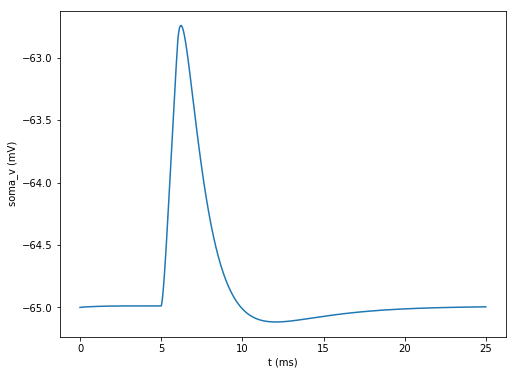

In [26]:
plt.figure(figsize=(8,6))
plt.plot(t, soma_v)
plt.xlabel('t (ms)')
plt.ylabel('soma_v (mV)')
plt.show()

### Plotting both the dendrite and the soma

In [27]:
dend0_v = h.Vector().record(my_cell.dend0(0.5)._ref_v)

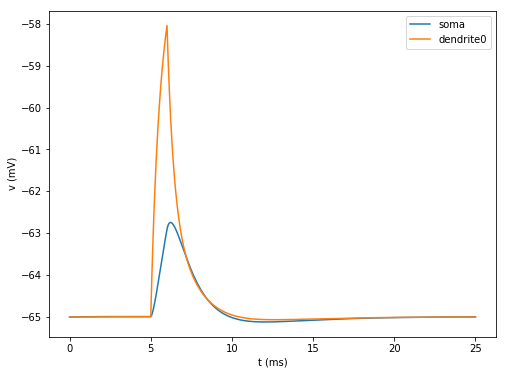

In [28]:
stim.amp = 0.1
h.finitialize(-65 * mV)
h.continuerun(25 * ms)
plt.figure(figsize=(8,6))
plt.plot(t, soma_v, label='soma')
plt.plot(t, dend0_v, label='dendrite0')
plt.xlabel('t (ms)')
plt.ylabel('v (mV)')
plt.legend()
plt.show()

## Exercise 2.1 : You can have a try that if you change the amplitude of the stimulus, how will the voltage of soma and dendrite change respectively?

### The role of nseg

In [29]:
my_cell.dend0.psection()

{'point_processes': {'IClamp': {IClamp[0]}},
 'density_mechs': {'pas': {'g': [0.001],
   'e': [-65.0],
   'i': [2.310476020070951e-06]}},
 'ions': {},
 'morphology': {'L': 200.0,
  'diam': [1.0],
  'pts3d': [],
  'parent': BallAndStick[0].soma(0),
  'trueparent': None},
 'nseg': 1,
 'Ra': 100.0,
 'cm': [1.0],
 'regions': set(),
 'species': set(),
 'name': 'BallAndStick[0].dend0',
 'hoc_internal_name': '__nrnsec_0x3097a80',
 'cell': BallAndStick[0]}

**section.nseg** : The section is divided into nseg compartments of length L/nseg. Membrane potential will be computed at the ends of the section and the middle of each compartment. At the midpoint of each segment, the difference equation satisfies the law of conservation of current. Therefore, the more segments are divided, the higher the numerical accuracy.

<center class='half'>
    <img src='./pictures/segment.png' width='500'/>
    <img src='./pictures/segment2.png' width='400'/>
</center>

In [30]:
my_cell.dend0.nseg = 5

Normally, nseg is set to be an odd number for convenience

In [31]:
dend_v_1 = h.Vector().record(my_cell.dend0(0.1)._ref_v)
dend_v_2 = h.Vector().record(my_cell.dend0(0.3)._ref_v)
dend_v_3 = h.Vector().record(my_cell.dend0(0.5)._ref_v)
dend_v_4 = h.Vector().record(my_cell.dend0(0.7)._ref_v)
dend_v_5 = h.Vector().record(my_cell.dend0(0.9)._ref_v)

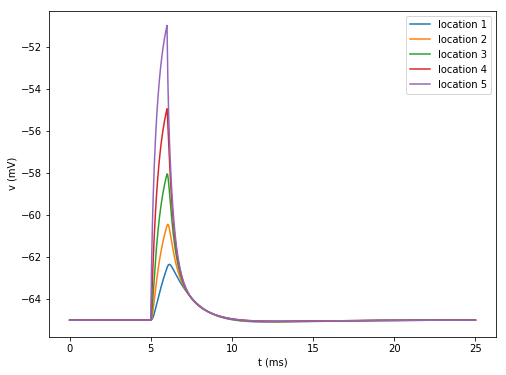

In [32]:
stim.amp = 0.1
h.finitialize(-65 * mV)
h.continuerun(25 * ms)
plt.figure(figsize=(8,6))
plt.plot(t, dend_v_1, label='location 1')
plt.plot(t, dend_v_2, label='location 2')
plt.plot(t, dend_v_3, label='location 3')
plt.plot(t, dend_v_4, label='location 4')
plt.plot(t, dend_v_5, label='location 5')
plt.xlabel('t (ms)')
plt.ylabel('v (mV)')
plt.legend()
plt.show()

In [33]:
my_cell.dend0.nseg = 1

In [34]:
dend_v_1 = h.Vector().record(my_cell.dend0(0.1)._ref_v)
dend_v_2 = h.Vector().record(my_cell.dend0(0.3)._ref_v)
dend_v_3 = h.Vector().record(my_cell.dend0(0.5)._ref_v)
dend_v_4 = h.Vector().record(my_cell.dend0(0.7)._ref_v)
dend_v_5 = h.Vector().record(my_cell.dend0(0.9)._ref_v)

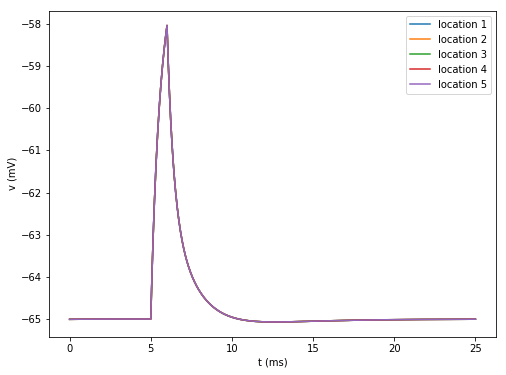

In [35]:
stim.amp = 0.1
h.finitialize(-65 * mV)
h.continuerun(25 * ms)
plt.figure(figsize=(8,6))
plt.plot(t, dend_v_1, label='location 1')
plt.plot(t, dend_v_2, label='location 2')
plt.plot(t, dend_v_3, label='location 3')
plt.plot(t, dend_v_4, label='location 4')
plt.plot(t, dend_v_5, label='location 5')
plt.xlabel('t (ms)')
plt.ylabel('v (mV)')
plt.legend()
plt.show()

## Exercise 2.2: Try to build a neuron with a soma connected with a dendrite. Change the nseg of the dendrite to see how the nseg affects the resolution of the simulation?

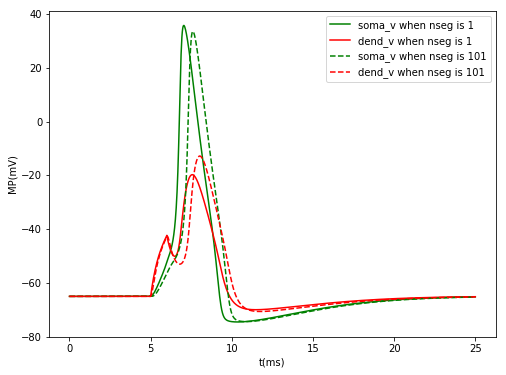

In [39]:
## Uncomment the code below and fill in the blank

class BallAndStick:
    def __init__(self, gid):
        self._gid = gid
        self._setup_morphology()
        self._setup_biophysics()
    def _setup_morphology(self):
        self.soma = h.Section(name='soma', cell=self)
        self.dend = h.Section(name='dend', cell=self)
        self.all = [self.soma, self.dend]
        self.dend.connect(self.soma(1)) # connect the dend with soma
        self.soma.L = self.soma.diam = 12.6157 # change the length and diamter of soma to 12.6157um
        self.dend.L = 200 # change the length of dendrite to 200um
        self.dend.diam = 1 # change the diameter of dendrite to 1um
    def _setup_biophysics(self):
        for sec in self.all:
            sec.Ra = 100    # Axial resistance in Ohm * cm
            sec.cm = 1      # Membrane capacitance in micro Farads / cm^2
        self.soma.insert('hh') # Insert HH channel in soma                                       
        for seg in self.soma:
            seg.hh.gnabar = 0.12  # Sodium conductance in S/cm2
            seg.hh.gkbar = 0.036  # Potassium conductance in S/cm2
            seg.hh.gl = 0.0003    # Leak conductance in S/cm2
            seg.hh.el = -54.3     # Reversal potential in mV                      
        self.dend.insert('pas')  # Insert passive channel in dendrite                                       
        for seg in self.dend:                                          
            seg.pas.g = 0.001  # Passive conductance in S/cm2         
            seg.pas.e = -65    # Leak reversal potential mV            
    def __repr__(self):
        return 'BallAndStick[{}]'.format(self._gid)

my_cell = BallAndStick(0)

stim = h.IClamp(my_cell.dend(1)) #stimulate the neuron at dend(1)
stim.delay = 5
stim.dur = 1
stim.amp = 0.3

soma_v = h.Vector().record(my_cell.soma(0.5)._ref_v)
dend_v = h.Vector().record(my_cell.dend(0.5)._ref_v)
t = h.Vector().record(h._ref_t)

plt.figure(figsize=(8, 6))
colors = ['green', 'blue', 'red', 'black']
for my_cell.dend.nseg in [1, 101]:
    h.finitialize(-65)
    h.continuerun(25)
    if my_cell.dend.nseg == 1:
        plt.plot(t, soma_v, label=f'soma_v when nseg is {my_cell.dend.nseg}', color = 'green')
        plt.plot(t, dend_v,  label=f'dend_v when nseg is {my_cell.dend.nseg}', color = 'red')
    else:
        plt.plot(t, soma_v, ls='--', label=f'soma_v when nseg is {my_cell.dend.nseg}', color = 'green')
        plt.plot(t, dend_v, ls='--', label=f'dend_v when nseg is {my_cell.dend.nseg}', color = 'red')
plt.xlabel('t(ms)')
plt.ylabel('MP(mV)')
plt.legend()
plt.show()